## Интеллектуальный анализ данных – весна 2022
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.datasets import load_wine
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [3]:
X.isnull().any().any() # пропусков нет

False

In [4]:
X.info() # категориальных данных нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
scaler = StandardScaler()
 
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

X_train_scale = pd.DataFrame(data=X_train_scale, columns=X_train.columns)
X_test_scale = pd.DataFrame(data=X_test_scale, columns=X_test.columns)

In [7]:
# Оставляем только два признака
X_train_two_feat = X_train_scale[['alcohol', 'magnesium']]
X_test_two_feat = X_test_scale[['alcohol', 'magnesium']]

In [8]:
def variation_knn(n_neighbors=1):
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    knn.fit(X_train_two_feat, y_train)
    
    y_train_pred = knn.predict(X_train_two_feat)    
    y_pred = knn.predict(X_test_two_feat)
    
    return {'train': round(accuracy_score(y_train, y_train_pred), 2), 
            'test': round(accuracy_score(y_test, y_pred), 2),
            'model': knn
           }

In [9]:
knn_1 = variation_knn()
knn_3 = variation_knn(3)
knn_5 = variation_knn(5)
knn_10 = variation_knn(10)
knn_15 = variation_knn(15)
knn_25 = variation_knn(25)

results_knn = pd.DataFrame(columns=['NN', 'Train', 'Test'])
results_knn['NN'] = [1, 3, 5, 10, 15, 25]
results_knn['Train'] = [knn_1['train'], knn_3['train'], knn_5['train'], knn_10['train'], knn_15['train'], knn_25['train']]
results_knn['Test'] = [knn_1['test'], knn_3['test'], knn_5['test'], knn_10['test'], knn_15['test'], knn_25['test']]

In [10]:
results_knn

,NN,Train,Test
0,1,0.99,0.67
1,3,0.84,0.65
2,5,0.81,0.69
3,10,0.81,0.70
4,15,0.78,0.69
5,25,0.73,0.69


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [11]:
# !pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [12]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

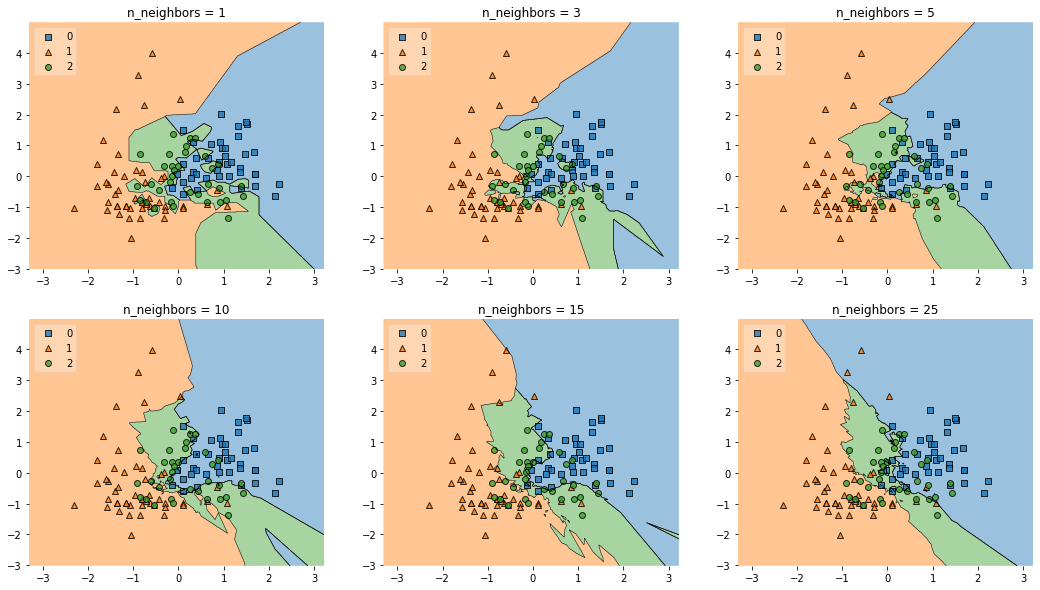

In [13]:
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(18, 10))

labels = ['n_neighbors = 1', 'n_neighbors = 3', 'n_neighbors = 5',
          'n_neighbors = 10', 'n_neighbors = 15', 'n_neighbors = 25']

for knn, lab, grd in zip([knn_1['model'], knn_3['model'], knn_5['model'], 
                          knn_10['model'], knn_15['model'], knn_25['model']],
                         labels,
                         itertools.product([0, 1], [0, 1, 2], repeat=1)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_two_feat.to_numpy(), y=y_train, clf=knn, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

Можно заметить, что при **n_neighbors=1** модель очень сильно переобучается, это видно и по accuracy (сильное различие между трейном и тестом), и по визуализации - многократное деление областей для нескольких объектов первый флажок на переобучение, а здесь этих областей для зеленого класса очень много, итог - это очень плохая модель

Оптимальное количество соседей - модели с **n_neighbors=5**, **n_neighbors=10** и **n_neighbors=15** очень похожи, и по визаулизации, и по метрикам, нужно выбрать одну модель из них. Изначально кажется, что n_neighbors=5 оптимально, потому что разделяющие поверхности более плавные по краям разделяющих поверхностей, но нужно копнуть глубже, нам важно, чтобы разделяющие поверхности были менее "рваными" в центре скопления точек, где сосредоточена большая часть зеленых, синих и частично оранжевых точек, потому что распределение данных таково, что данные тянутся вытянутым "облаком" почти по диагонали, и большая часть расположена именно в центре, если в центре есть рваности, то это признак переобучения. Наименее рваным из этих графиков в центре является модель при **n_neighbors=15**, также разница между трейном и тестом в accuracy наименьшая среди этих трех моделей, что дает надежду на бОльшую устойчивость модели.

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

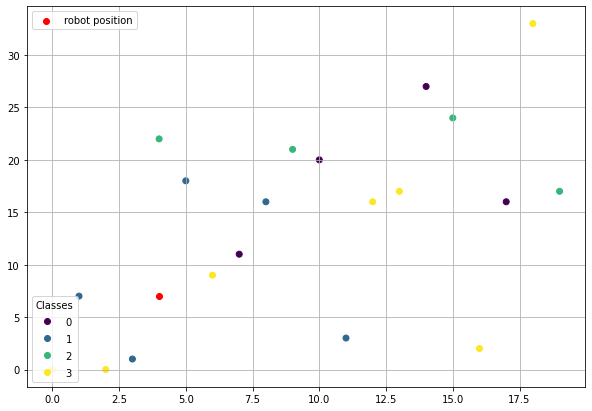

In [14]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [15]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        
        '''
        # Store the history of movements
        self.trajectory = [initial_position]
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        self.knn.fit(landmarks, classes)
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        '''
        Calculate new position of the robot and add it to the history
        '''
        last_position = self.trajectory[-1]
        
        self.mask = np.random.binomial(1, 0.2)
        next_position = self.mask * self.mapping[0] + \
                             (1 - self.mask) * self.mapping[self.knn.predict(last_position.reshape(1, -1))[0]]
        
        self.trajectory.append(last_position + next_position)

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [16]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = np.vstack(robot.trajectory)
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

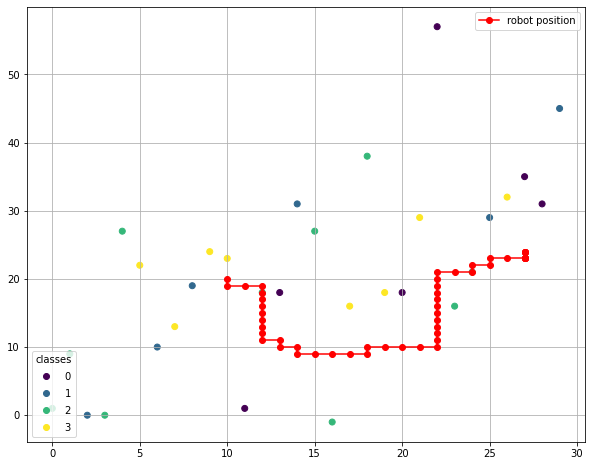

In [17]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

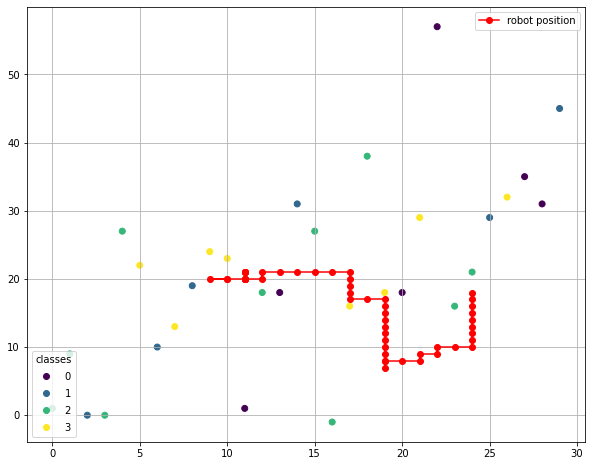

In [18]:
conduct_experiment(x, mean = 3, std = 10, k = 1, n_movements = 50)

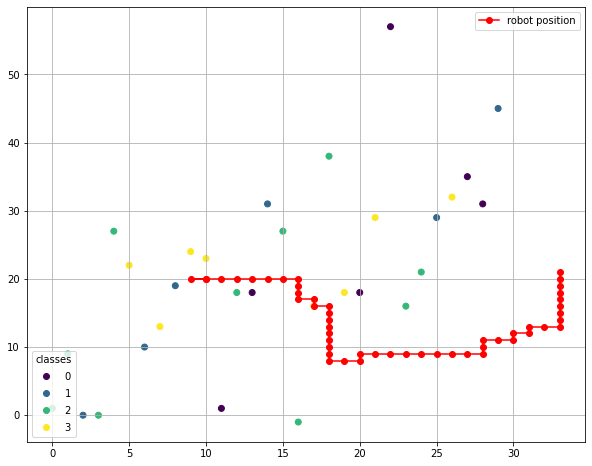

In [19]:
conduct_experiment(x, mean = 3, std = 10, k = 3, n_movements = 50)

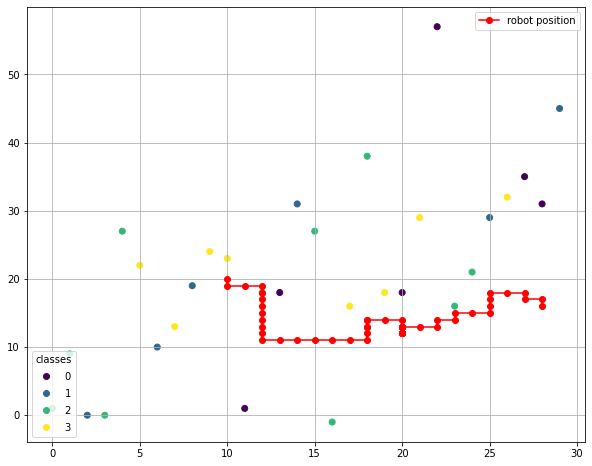

In [20]:
conduct_experiment(x, mean = 3, std = 10, k = 10, n_movements = 50)

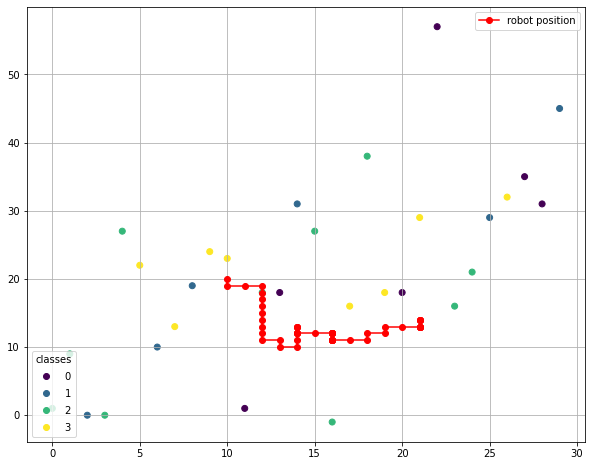

In [21]:
conduct_experiment(x, mean = 3, std = 10, k = 15, n_movements = 50)

1. **Чем больше соседей, тем более стохастичный график**, интутивно это выглядит так: когда рассматриваем мало точек возле положения робота, то направление движения, как правило, сохраняется долгое время, после чего меняется, если же берем вокруг много точек, то получается другая картина, так как точки случайно разбросаны, то вокруг положения робота расположены "разношерстные" точки, то есть разных классов, и при каком-то маленьком сдвиге, количество одного класса начинает преобладать над другим, поэтому график получается более случайный, а также по визуализации менее растянутый, как раз ввиду частых изменений направлений.

2. **Если бы метки назначались не случайно, а осмысленно**, то картина была бы немного другая. Наверное, это были бы несколько классов, разделенных на отдельные кластеры, в одной части плоскости был бы один класс, в другой части второй класс и аналогично другие классы. Тогда бы движение робота было бы более прямолинейным и не шумным, то есть, двигаясь в области одного класса, он продолжал бы движение примерно в одном направлении, потом, приближаясь к другому классу, менял направление движения.

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [22]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [23]:
data.isnull().any().any() # пропусков в данных нет

False

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [24]:
# бессмысленный столбец, обычно он появляется, когда сохраняешь csv без аргумента index=False
data.drop(['Unnamed: 0'], axis=1, inplace=True) 

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [25]:
# Для наглядности переместим колонку price в конец
data = data.reindex(columns=['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price'])

In [26]:
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,carat,depth,table,x,y,z,price
carat,1.00,0.03,0.18,0.98,0.95,0.95,0.92
depth,0.03,1.00,-0.30,-0.03,-0.03,0.09,-0.01
table,0.18,-0.30,1.00,0.20,0.18,0.15,0.13
x,0.98,-0.03,0.20,1.00,0.97,0.97,0.88
y,0.95,-0.03,0.18,0.97,1.00,0.95,0.87
z,0.95,0.09,0.15,0.97,0.95,1.00,0.86
price,0.92,-0.01,0.13,0.88,0.87,0.86,1.00


Нам нужно обратить внимание на последний столбец - в нем указана **корреляция** между таргетом price и остальными вещественными фичами

Топ 3 коррелируемых признака:

    1. carat (вес)
    2. x (длина)
    3. y (ширина)

Это достаточно интерпретируемо, потому что в реальной жизни от этих признаков действительно сильно зависит цена драгоценных камней

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [27]:
data_dum = pd.get_dummies(data, drop_first=True)

**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [28]:
X_lr = data_dum.drop('price', axis=1)
y_lr = data_dum['price']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state=42)

In [29]:
X_train_lr.reset_index(drop=True, inplace=True)
X_test_lr.reset_index(drop=True, inplace=True)
y_train_lr.reset_index(drop=True, inplace=True)
y_test_lr.reset_index(drop=True, inplace=True)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [30]:
scaler_lr = StandardScaler()

# делаем scale только для вещественных признаков, для one-hot признаков это делаеть не нужно
X_train_lr_scale = scaler_lr.fit_transform(X_train_lr[X_train_lr.columns[:6]])
X_test_lr_scale = scaler_lr.transform(X_test_lr[X_test_lr.columns[:6]])

X_train_lr_scale = pd.DataFrame(data=X_train_lr_scale, columns=X_train_lr.columns[:6])
X_test_lr_scale = pd.DataFrame(data=X_test_lr_scale, columns=X_test_lr.columns[:6])

# склеиваем отмаcштабированные признаки с one-hot признаками
X_train_lr_final = pd.concat([X_train_lr_scale, X_train_lr[X_train_lr.columns[6:]]], axis=1)
X_test_lr_final = pd.concat([X_test_lr_scale, X_test_lr[X_test_lr.columns[6:]]], axis=1)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [31]:
model = LinearRegression()
model.fit(X_train_lr_final, y_train_lr)

y_train_pred_lr = model.predict(X_train_lr_final)
y_pred_lr = model.predict(X_test_lr_final)

print(f'Train MSE: {mean_squared_error(y_train_pred_lr, y_train_lr)} \n\nTest MSE: {mean_squared_error(y_test_lr, y_pred_lr)}')

Train MSE: 1290541.9147450614 

Test MSE: 1244765.4357158698


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [32]:
# https://stackoverflow.com/questions/26951880/scikit-learn-linear-regression-how-to-get-coefficients-respective-features
cdf = pd.DataFrame(model.coef_, X_lr.columns, columns=['Coefficients'])

In [33]:
cdf[:6]

,Coefficients
carat,5338.615671
depth,-90.173817
table,-60.332280
x,-1100.418850
y,-6.458917
z,-34.258945


Самые большие по модулю веса перед признаками **carat** и **x**

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [34]:
def ridge_lasso(alpha):
    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_lr_final, y_train_lr)

    ridge_coef = pd.DataFrame(ridge.coef_, X_lr.columns, columns=['Coeffs_Ridge'])[:6]


    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_lr_final, y_train_lr)

    lasso_coef = pd.DataFrame(lasso.coef_, X_lr.columns, columns=['Coeffs_Lasso'])[:6]
    
    coefs = pd.concat([ridge_coef, lasso_coef], axis=1)
    
    return coefs

In [35]:
ridge_lasso(10)

,Coeffs_Ridge,Coeffs_Lasso
carat,5286.285876,4756.602190
depth,-93.746314,-153.122715
table,-63.430106,-109.868576
x,-1062.006514,-681.275333
y,-5.916126,-0.000000
z,-33.689994,-6.279439


* После применения Ridge регрессии с таким альфа веса поменялись не сильно, но после применения Lasso регрессии изменения более значимы, ненужные признаки она пытается занулить в связи с чем происходят такие значительные изменения

* Изначально очень сильная корреляция между весом и рамерными характеристиками бриллиантов, это видно и по матрице корреляций, и по весам. Веса перед **carat** и **x** очень сильно отличаются от остальных, что говорит о проблеме мультиколлинеарности

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [36]:
coefs_01 = ridge_lasso(0.1)
coefs_1 = ridge_lasso(1)
coefs_10 = ridge_lasso(10)
coefs_100 = ridge_lasso(100)
coefs_200 = ridge_lasso(200)

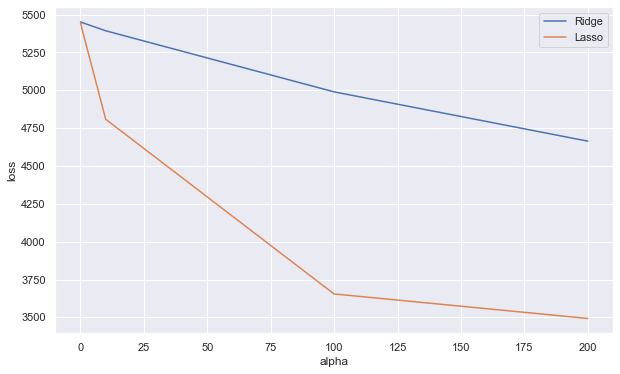

In [37]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10, 6))

x = [0.1, 1, 10, 100, 200]

y_ridge = [np.linalg.norm(coefs_01['Coeffs_Ridge'].values),
       np.linalg.norm(coefs_1['Coeffs_Ridge'].values),
       np.linalg.norm(coefs_10['Coeffs_Ridge'].values),
       np.linalg.norm(coefs_100['Coeffs_Ridge'].values),
       np.linalg.norm(coefs_200['Coeffs_Ridge'].values)]

y_lasso = [np.linalg.norm(coefs_01['Coeffs_Lasso'].values),
       np.linalg.norm(coefs_1['Coeffs_Lasso'].values),
       np.linalg.norm(coefs_10['Coeffs_Lasso'].values),
       np.linalg.norm(coefs_100['Coeffs_Lasso'].values),
       np.linalg.norm(coefs_200['Coeffs_Lasso'].values)]

sns.lineplot(x, y_ridge, label='Ridge')
sns.lineplot(x, y_lasso, label='Lasso')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.legend()
plt.show()

* Lasso агрессивнее уменьшает веса

* Lasso чаще используют для отбора признаков, потому что такая регуляризация приводит к более разреженным моделям с меньшим количеством коэффициентов, зануляя их

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [38]:
# кросс-валидация
lasso_cv = LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5)
lasso_cv.fit(X_train_lr_final, y_train_lr)

LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5)

In [39]:
# усредненные ошибки, наименьшней является ошибка по последнему индексу
lasso_cv.mse_path_.mean(axis=1)

array([2454496.08920843, 2253981.9244711 , 1531830.98890377,
       1298203.20783827, 1295874.3166597 ])

In [40]:
# последний индекс занимает alpha=0.1 - оптимальный параметр
lasso_cv.alphas_

array([2.e+02, 1.e+02, 1.e+01, 1.e+00, 1.e-01])

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [41]:
lasso_best = Lasso(alpha=0.1)
lasso_best.fit(X_train_lr_final, y_train_lr)

Lasso(alpha=0.1)

In [42]:
lasso_best_coefs = pd.DataFrame(lasso_best.coef_, X_lr.columns, columns=['Coeffs_Lasso_best'])[:6]

In [43]:
lasso_best_coefs

,Coeffs_Lasso_best
carat,5332.422145
depth,-91.073033
table,-60.981853
x,-1096.815363
y,-5.607738
z,-33.944427


- Наиболее информативные веществ. признаки: *carat* и *x*
- Наименее информативные веществ. признаки: *depth*, *table*, *y*, *z*


Это можно проверить, удаляя признаки из датасета и смотря на лосс, если удаляем неинформативные признаки, лосс не сильно возрастает и почти не меняется, если же удалим информативные признаки, лосс вырастает очень значительно. 

P.S. проверял, если удалить признак *carat* - лосс возрастает в два раза

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [44]:
y_pred_lasso = lasso_best.predict(X_test_lr_final)
mse_best = mean_squared_error(y_test_lr, y_pred_lasso)

print(f'Best MSE Lasso: {mse_best}\n\nMSE 3.13 < MSE 3.7: {mse_best < mean_squared_error(y_test_lr, y_pred_lr)}')

Best MSE Lasso: 1244336.150823827

MSE 3.13 < MSE 3.7: True


Модель после применения регуляризации Lasso оказалась совсем чуть-чуть лучше, лоссы почти идентичные, это происходит потому, что коэффициент регуляризации мал, веса почти не меняются, а бОльшие коэффициенты регуляризации приводят к тому, что ошибка увеличивается и становится хуже, чем просто без регуляризации